In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, fftfreq, rfftfreq
import os, re
os.chdir("/home")
print(os.getcwd())

/home


---
Reading data from three different flights (with the first file containing concatenated data from two flights)


In [16]:
data_15 = pd.read_csv('data/gyro_acc_lot_03_15.csv')
data_35 = pd.read_csv('data/gryo_acc_lot_10_35.csv')


In [17]:
data_15.head()

,timestamp(ms),degrees(IMU[0].GyrX),degrees(IMU[0].GyrY),degrees(IMU[0].GyrZ),IMU[0].AccX,IMU[0].AccY,IMU[0].AccZ
0,56995.851,-0.032568,-0.106268,0.069404,-0.215246,0.459727,-9.890145
1,57095.851,-0.050129,-0.080863,0.047958,-0.218031,0.458423,-9.896425
2,57195.851,-0.039158,-0.043306,0.006790,-0.217225,0.457481,-9.892200
3,57295.851,-0.034236,-0.098692,0.028611,-0.215400,0.461080,-9.905223
4,57395.851,-0.060214,-0.060917,0.029124,-0.221406,0.463030,-9.899725


---
Verifying the obtained data; this file contains data from a flight with healthy rotor blades and one with a 1.5 cm damage.

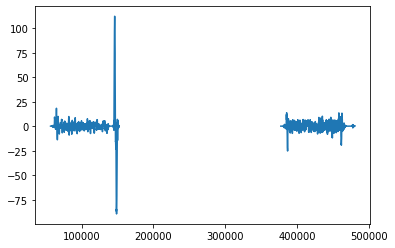

In [38]:
plt.plot(data_15['timestamp(ms)'],data_15['degrees(IMU[0].GyrZ)'])
plt.show()

In [19]:
def get_first_last_none_index(df, column_name):
    column = df[column_name]
    first_none_index = column.index[column.isnull()].min()
    last_none_index = column.index[column.isnull()].max()
    return first_none_index, last_none_index

def split_array(array, segment_size, overlap):
    splitted_segments = []
    i = 0
    while i < len(array):
        if len(array[i:i+segment_size]) == segment_size:
            splitted_segments.append(array[i:i+segment_size])
        i += segment_size - overlap
    return splitted_segments

def split_aggregation(array,first_segment,agg):
    splitted_segments = []
    i = 0
    while first_segment+agg*i < len(array):
        splitted_segments.append(array[:first_segment+agg*i])
        i += 1
    return splitted_segments

def get_acc(arr1,arr2,arr3):
    sum_of_squares = np.square(arr1) + np.square(arr2) + np.square(arr3)
    result = np.sqrt(sum_of_squares)
    return result

def normalization(data):
    min_data = min(data)
    diff_data = max(data) - min_data
    return [(x-min_data)/diff_data for x in data]

def FFT_data(data_array,df=True):
    data_dict = {}
    signal_size = 500
    sample_rate = 1000
    skip_unit_jump = 10 #on the first values is noise as unit jump, so we skip them
    fft_freq = rfftfreq(signal_size, d=1/sample_rate)

    data_dict['Frequencies'] = fft_freq[skip_unit_jump:]
    for index,data in enumerate(data_array):
        fft_val = abs(rfft(data,n=signal_size))
        data_dict[f'Sample {index+1}'] = normalization(fft_val[skip_unit_jump:])
    if df:
        return pd.DataFrame.from_dict(data_dict)
    else:
        return data_dict


---

In [41]:
# Get the first and last indices for data_15
first, second = get_first_last_none_index(data_15, 'IMU[0].AccY')

# Calculate time for "healthy" data
time_healthy = data_15['timestamp(ms)'].values[:first] - min(data_15['timestamp(ms)'].values[:first])

# Calculate time for "damaged" data
time_damaged = data_15['timestamp(ms)'].values[second + 1:] - min(data_15['timestamp(ms)'].values[second + 1:])

# Calculate time for "very damaged" data
time_very_damaged = data_35['timestamp(ms)'].values - min(data_35['timestamp(ms)'].values)

# Get accelerometer data for "healthy" state
acc_X_healthy = data_15['IMU[0].AccX'].values[:first]
acc_Y_healthy = data_15['IMU[0].AccY'].values[:first]
acc_Z_healthy = data_15['IMU[0].AccZ'].values[:first]
acc_healthy = get_acc(acc_X_healthy, acc_Y_healthy, acc_Z_healthy)  # 50 210

# Get gyroscope data for "healthy" state
gyro_X_healthy = data_15['degrees(IMU[0].GyrX)'].values[:first]
gyro_Y_healthy = data_15['degrees(IMU[0].GyrY)'].values[:first]
gyro_Z_healthy = data_15['degrees(IMU[0].GyrZ)'].values[:first]
gyro_healthy = get_acc(gyro_X_healthy, gyro_Y_healthy, gyro_Z_healthy)  # 50 210

# Get accelerometer data for "damaged" state
acc_X_damaged = data_15['IMU[0].AccX'].values[second + 1:]
acc_Y_damaged = data_15['IMU[0].AccY'].values[second + 1:]
acc_Z_damaged = data_15['IMU[0].AccZ'].values[second + 1:]
acc_damaged = get_acc(acc_X_damaged, acc_Y_damaged, acc_Z_damaged)  # 50 190

# Get gyroscope data for "damaged" state
gyro_X_damaged = data_15['degrees(IMU[0].GyrX)'].values[second + 1:]
gyro_Y_damaged = data_15['degrees(IMU[0].GyrY)'].values[second + 1:]
gyro_Z_damaged = data_15['degrees(IMU[0].GyrZ)'].values[second + 1:]
gyro_damaged = get_acc(gyro_X_damaged, gyro_Y_damaged, gyro_Z_damaged)  # 50 190

# Get accelerometer data for "very damaged" state
acc_X_very_damaged = data_35['IMU[0].AccX'].values
acc_Y_very_damaged = data_35['IMU[0].AccY'].values
acc_Z_very_damaged = data_35['IMU[0].AccZ'].values

# Get gyroscope data for "very damaged" state
gyro_X_very_damaged = data_35['degrees(IMU[0].GyrX)'].values
gyro_Y_very_damaged = data_35['degrees(IMU[0].GyrY)'].values
gyro_Z_very_damaged = data_35['degrees(IMU[0].GyrZ)'].values

# Calculate accelerometer values for "very damaged" state
acc_very_damaged = get_acc(acc_X_very_damaged, acc_Y_very_damaged, acc_Z_very_damaged)  # 5 135

# Calculate gyroscope values for "very damaged" state
gyro_very_damaged = get_acc(gyro_X_very_damaged, gyro_Y_very_damaged, gyro_Z_very_damaged)  # 5 135


In [22]:
start = 50
stop = 150

---
Comparing acceleration signals after drone takeoff with different rotor blade conditions.

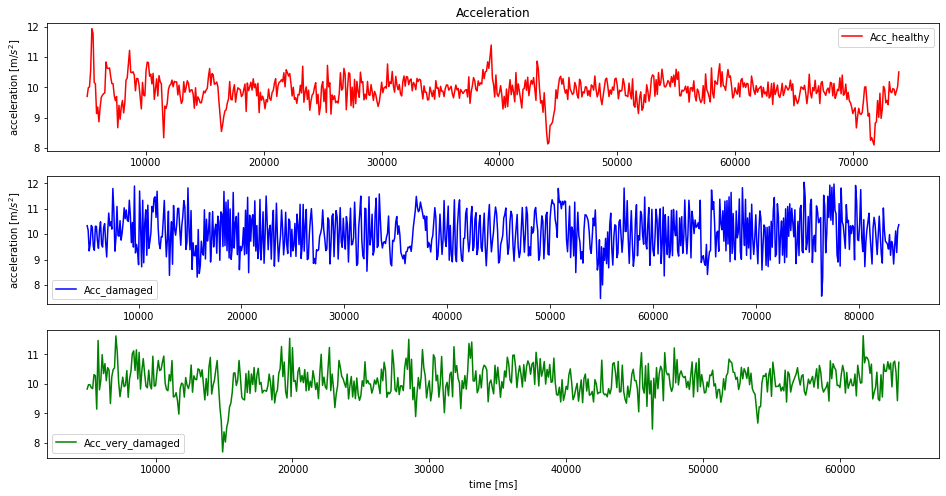

In [48]:
fig,ax = plt.subplots(3,1,figsize=[16,8])


ax[0].set_title('Acceleration')
ax[0].plot(time_healthy[start:len(time_healthy)-210], acc_healthy[start:len(time_healthy)-210], label='Acc_healthy',color='red')
ax[1].plot(time_damaged[start:len(time_damaged)-190], acc_damaged[start:len(time_damaged)-190], label='Acc_damaged',color='blue')
ax[2].plot(time_very_damaged[start:len(time_very_damaged)-135], acc_very_damaged[start:len(time_very_damaged)-135], label='Acc_very_damaged',color='green')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel(r'acceleration [m/$s^2$]')
ax[1].set_ylabel(r'acceleration [m/$s^2$]')
ax[2].set_xlabel('time [ms]')
plt.show()

In [24]:
acc_healthy_split = split_array(acc_healthy[50:len(acc_healthy)-210],150,125)
acc_damaged_split = split_array(acc_damaged[50:len(acc_damaged)-190],150,125)
acc_very_damaged_split = split_array(acc_very_damaged[50:len(acc_very_damaged)-135],150,125)

In [25]:
columns_h = [f'Sample {x}' for x in range(len(acc_healthy_split))]
columns_d = [f'Sample {x}' for x in range(len(acc_damaged_split))]
columns_vd = [f'Sample {x}' for x in range(len(acc_very_damaged_split))]

In [26]:
data_healthy = pd.DataFrame(acc_healthy_split).T
data_damaged = pd.DataFrame(acc_damaged_split).T
data_very_damaged = pd.DataFrame(acc_very_damaged_split).T
data_healthy.columns = columns_h
data_damaged.columns = columns_d
data_very_damaged.columns = columns_vd

---
Save accelerometer data in the time domain.

In [27]:
data_healthy.to_csv('data_preprocesed/acc_healthy_samples.csv')
data_damaged.to_csv('data_preprocesed/acc_damaged_samples.csv')
data_very_damaged.to_csv('data_preprocesed/acc_very_damaged_samples.csv')

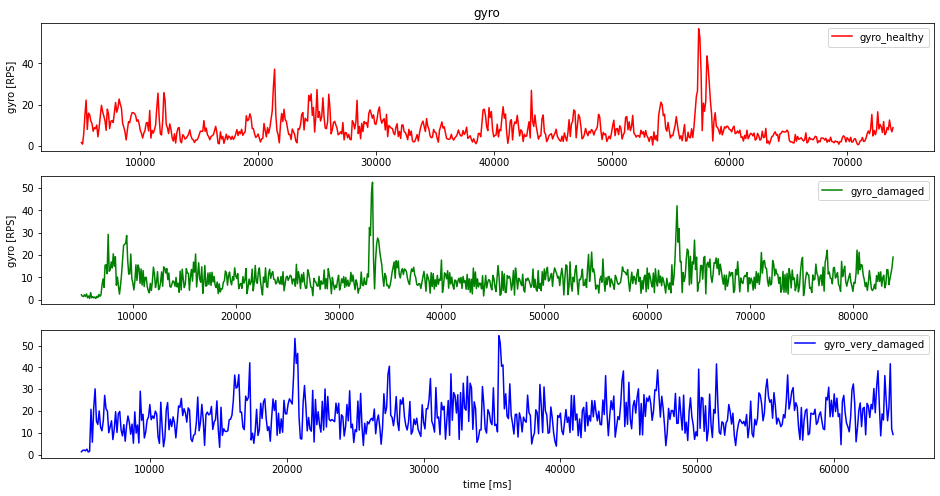

In [47]:
fig,ax = plt.subplots(3,1,figsize=[16,8])
ax[0].set_title('gyro')
ax[0].plot(time_healthy[50:len(time_healthy)-210], gyro_healthy[50:len(time_healthy)-210], label='gyro_healthy',color='red')
ax[1].plot(time_damaged[50:len(time_damaged)-190], gyro_damaged[50:len(time_damaged)-190], label='gyro_damaged',color='green')
ax[2].plot(time_very_damaged[50:len(time_very_damaged)-135],gyro_very_damaged[50:len(time_very_damaged)-135],label='gyro_very_damaged',color='blue')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('gyro [RPS]')
ax[1].set_ylabel('gyro [RPS]')
ax[2].set_xlabel('time [ms]')
plt.show()

---
Performing Fourier transform to obtain gyroscope data in the frequency domain.

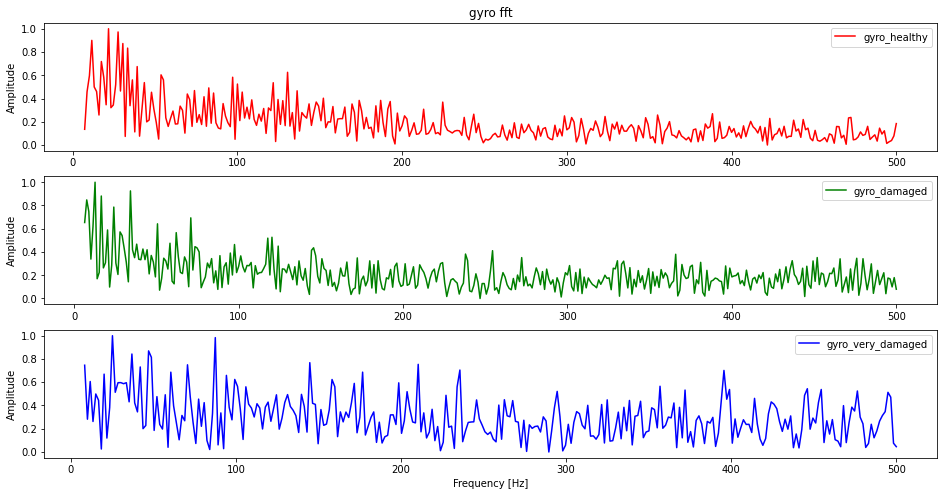

In [49]:
fft_val_h = abs(rfft(gyro_healthy[50:len(gyro_healthy)-210]))
fft_freq_h = rfftfreq(len(gyro_healthy[50:len(gyro_healthy)-210]),d=1/1000)

fft_val_d = abs(rfft(gyro_damaged[50:len(gyro_damaged)-190]))
fft_freq_d = rfftfreq(len(gyro_damaged[50:len(gyro_damaged)-190]),d=1/1000)

fft_val_vd = abs(rfft(gyro_very_damaged[50:len(gyro_very_damaged)-135]))
fft_freq_vd = rfftfreq(len(gyro_very_damaged[50:len(gyro_very_damaged)-135]),d=1/1000)

fig,ax = plt.subplots(3,1,figsize=[16,8])
ax[0].set_title('gyro fft')
ax[0].plot(fft_freq_h[5:], normalization(fft_val_h[5:]), label='gyro_healthy',color='red')
ax[1].plot(fft_freq_d[5:], normalization(fft_val_d[5:]), label='gyro_damaged',color='green')
ax[2].plot(fft_freq_vd[5:],normalization(fft_val_vd[5:]),label='gyro_very_damaged',color='blue')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('Amplitude')
ax[1].set_ylabel('Amplitude')
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency [Hz]')
plt.show()

In [30]:
gyro_healthy_split = split_array(gyro_healthy[50:len(gyro_healthy)-210],150,125)
gyro_damaged_split = split_array(gyro_damaged[50:len(gyro_damaged)-190],150,125)
gyro_very_damaged_split = split_array(gyro_very_damaged[50:len(gyro_very_damaged)-135],150,125)

---
Save gyroscope data in the frequency domain.

In [31]:
df_gyro_healthy = FFT_data(gyro_healthy_split)
df_gyro_damaged = FFT_data(gyro_damaged_split)
df_gyro_very_damaged = FFT_data(gyro_very_damaged_split)

df_gyro_healthy.to_csv('data_preprocesed/gyro_healthy_samples.csv')
df_gyro_damaged.to_csv('data_preprocesed/gyro_damaged_samples.csv')
df_gyro_very_damaged.to_csv('data_preprocesed/gyro_very_damaged_samples.csv')

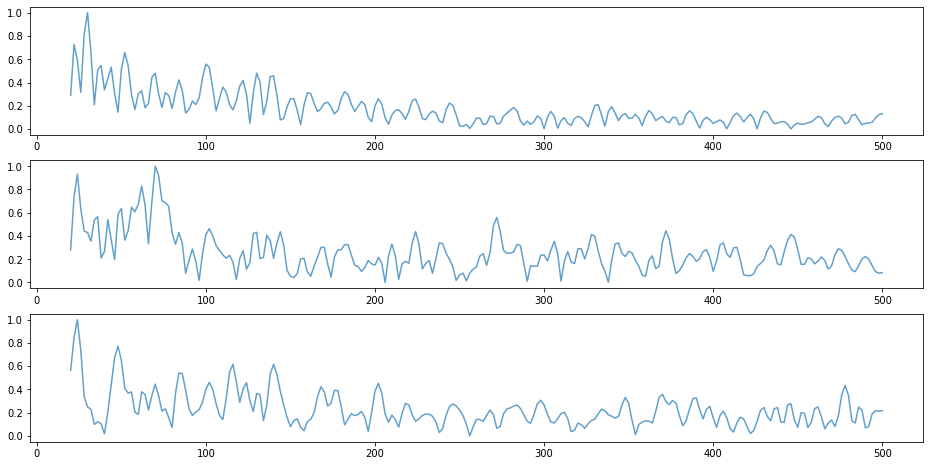

In [32]:
freq = df_gyro_healthy['Frequencies']
samples_1 = [x for x in df_gyro_healthy.columns if 'Sample' in x]
samples_2 = [x for x in df_gyro_damaged.columns if 'Sample' in x]
samples_3 = [x for x in df_gyro_very_damaged.columns if 'Sample' in x]

fig,ax = plt.subplots(3,1,figsize=[16,8])
for col in samples_1[1:2]:
    ax[0].plot(freq,df_gyro_healthy[col],alpha = 0.7)

for col in samples_2[1:2]:
    ax[1].plot(freq,df_gyro_damaged[col],alpha = 0.7)

for col in samples_3[1:2]:
    ax[2].plot(freq,df_gyro_very_damaged[col],alpha = 0.7)

In [33]:
gyro_agg_healthy_split = split_aggregation(gyro_healthy[50:len(gyro_healthy)-210],125,25)
gyro_agg_damaged_split = split_aggregation(gyro_damaged[50:len(gyro_damaged)-190],125,25)
gyro_agg_very_damaged_split = split_aggregation(gyro_very_damaged[50:len(gyro_very_damaged)-135],125,25)

---
Save gyroscope data in the frequency domain, but it has aggregated data from previous.


In [34]:
df_gyro_agg_healthy = FFT_data(gyro_agg_healthy_split)
df_gyro_agg_damaged = FFT_data(gyro_agg_damaged_split)
df_gyro_agg_very_damaged = FFT_data(gyro_agg_very_damaged_split)
df_gyro_agg_healthy.to_csv('data_preprocesed/gyro_agg_healthy_samples.csv')
df_gyro_agg_damaged.to_csv('data_preprocesed/gyro_agg_damaged_samples.csv')
df_gyro_agg_very_damaged.to_csv('data_preprocesed/gyro_agg_very_damaged_samples.csv')

In [35]:
df_gyro_agg_healthy.get('Frequencies')

0       20.0
1       22.0
2       24.0
3       26.0
4       28.0
       ...  
236    492.0
237    494.0
238    496.0
239    498.0
240    500.0
Name: Frequencies, Length: 241, dtype: float64

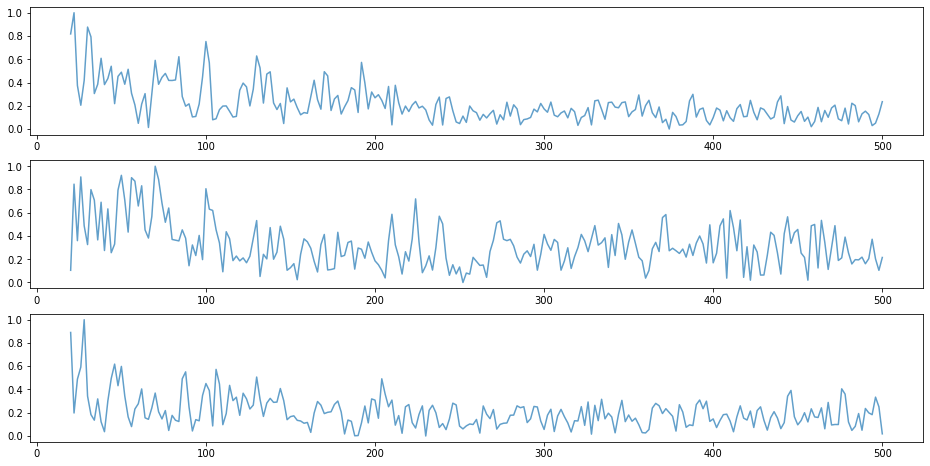

In [36]:
freq = df_gyro_agg_healthy['Frequencies']

samples_1 = [x for x in df_gyro_agg_healthy.keys() if 'Sample' in x]
samples_2 = [x for x in df_gyro_agg_damaged.keys() if 'Sample' in x]
samples_3 = [x for x in df_gyro_agg_very_damaged.keys() if 'Sample' in x]

fig,ax = plt.subplots(3,1,figsize=[16,8])
for col in samples_1[6:7]:
    ax[0].plot(freq,df_gyro_agg_healthy[col],alpha = 0.7)

for col in samples_2[6:7]:
    ax[1].plot(freq,df_gyro_agg_damaged[col],alpha = 0.7)

for col in samples_3[6:7]:
    ax[2].plot(freq,df_gyro_agg_very_damaged[col],alpha = 0.7)